# Met data for Sat Headwater

In [1]:
%matplotlib inline

In [2]:
import os
import workflow.conf

workflow.conf.set_data_directory(os.path.join(os.getcwd(), '..', 'data', 'raw'))

In [3]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import workflow
import workflow.source_list
import workflow.ui
import workflow.colors
import workflow.condition
import workflow.bin_utils
import workflow.plot

import datetime

workflow.ui.setup_logging(1,None)

In [4]:
# set up a dictionary of source objects
sources = workflow.source_list.get_default_sources()
workflow.source_list.log_sources(sources)

# specify the input shapefile and a hint as to what HUC it is in.
huc = '190604020404'
logging.info("")
logging.info("Meshing HUC: {}".format(huc))
logging.info("="*30)

# get the shape and crs of the shape
crs, hucs = workflow.get_split_form_hucs(sources['HUC'], huc, 12, crs=workflow.crs.default_alaska_crs())

2020-08-17 12:19:41,099 - root - INFO: Using sources:
2020-08-17 12:19:41,101 - root - INFO: --------------
2020-08-17 12:19:41,101 - root - INFO: HUC: National Watershed Boundary Dataset (WBD)
2020-08-17 12:19:41,102 - root - INFO: hydrography: National Hydrography Dataset (NHD)
2020-08-17 12:19:41,102 - root - INFO: DEM: National Elevation Dataset (NED)
2020-08-17 12:19:41,104 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2020-08-17 12:19:41,105 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2020-08-17 12:19:41,105 - root - INFO: soil thickness: None
2020-08-17 12:19:41,106 - root - INFO: meteorology: DayMet 1km
2020-08-17 12:19:41,107 - root - INFO: 
2020-08-17 12:19:41,108 - root - INFO: Meshing HUC: 190604020404
2020-08-17 12:19:41,109 - root - INFO: ==============================
2020-08-17 12:19:41,110 - root - INFO: 
2020-08-17 12:19:41,111 - root - INFO: Preprocessing HUC
2020-08-17 12

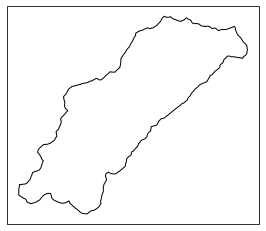

In [5]:
# plot the shape, does it look right?
fig, ax = workflow.plot.get_ax(crs)
workflow.plot.shply([hucs.exterior(),], crs, ax=ax)


In [6]:
# find the centroid in lat-long
huc_centroid = hucs.exterior().centroid
huc_centroid_ll = workflow.warp.xy(huc_centroid.xy[0], huc_centroid.xy[1], crs, workflow.crs.latlon_crs())
print('centroid at: (long-lat)', huc_centroid_ll)

centroid at: (long-lat) (array('d', [-149.07534301532525]), array('d', [68.25260782077336]))


In [7]:
import daymet_to_ats
start, end = daymet_to_ats.validate_start_end(None,None)
dm = daymet_to_ats.download_daymet('.', huc_centroid_ll[1][0], huc_centroid_ll[0][0], start, end)

2020-08-17 12:19:43,675 - root - INFO: Querying: https://daymet.ornl.gov/single-pixel/api/data?lat=68.2526&lon=-149.0753&vars=dayl,prcp,srad,swe,tmax,tmin,vp&start=1980-01-01&end=2018-12-31
2020-08-17 12:19:52,572 - root - INFO:   returned code: 200
2020-08-17 12:19:52,573 - root - INFO:   writing to disk: ./daymet_raw_68p2526_-149p0753.dat


In [8]:
ats = daymet_to_ats.daymet_to_ats(dm)
attrs = daymet_to_ats.daymet_attrs(huc_centroid_ll[1][0], huc_centroid_ll[0][0], start, end)
filename_out = daymet_to_ats.daymet_filename(huc_centroid_ll[1][0], huc_centroid_ll[0][0])
daymet_to_ats.write_ats(ats, attrs, filename_out)


2020-08-17 12:19:52,657 - root - INFO: Converting to ATS
2020-08-17 12:19:52,660 - root - INFO: Writing ATS file: daymet_raw_68p2526_-149p0753.h5


In [ ]:
# old filename prefix
old_prefix = filename_out[:-3] # remove .h5
new_prefix = 'daymet_sag-headwater'
os.rename(old_prefix+'.dat', new_prefix+'.dat')
os.rename(old_prefix+'.h5', new_prefix+'.h5')
